# Bezier Curves

## Original Bezier Curves

In [1]:
import sympy as sp

In [2]:
def get_bezier_polynomial(n):
    t, q = sp.symbols('t q')
    exprs = [sp.Symbol(f'p_{i}') for i in range(n+1)]
    while len(exprs) >= 2:
        next_exprs = []
        for i in range(len(exprs)-1):
            tmp_expr = q * exprs[i] + t * exprs[i+1]
            next_exprs.append(tmp_expr.expand())
        exprs = next_exprs
    return exprs[0].subs(q, 1-t)
get_bezier_polynomial(4)

p_0*(1 - t)**4 + 4*p_1*t*(1 - t)**3 + 6*p_2*t**2*(1 - t)**2 + 4*p_3*t**3*(1 - t) + p_4*t**4

In [3]:
def get_bezier_matrix(n):
    t = sp.symbols('t')
    I = sp.eye(n+1)
    matrix_t = sp.Matrix.hstack(*[sp.Matrix([t**i]) for i in range(n+1)])
    subs_dict = [(sp.Symbol(f'p_{i}'), I[:, i]) for i in range(n+1)]
    bezier_poly = get_bezier_polynomial(n).subs(subs_dict).T
    k1 = sp.Matrix.vstack(*[matrix_t.subs(t, i) for i in range(n+1)])
    k2 = sp.Matrix.vstack(*[bezier_poly.subs(t, i) for i in range(n+1)])
    return k1.inv()*k2
get_bezier_matrix(3)

Matrix([
[ 1,  0,  0, 0],
[-3,  3,  0, 0],
[ 3, -6,  3, 0],
[-1,  3, -3, 1]])

### Draw Bezier Curves

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

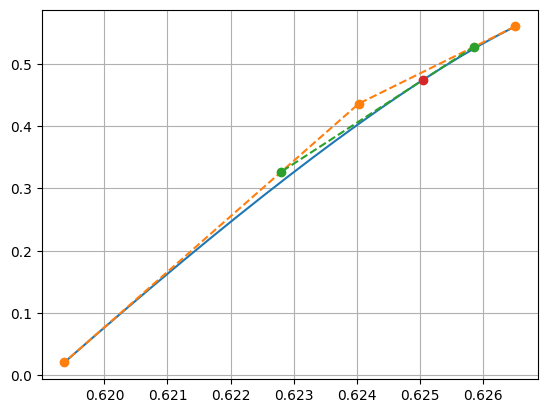

In [5]:
def bezier_2(t, q, p1, p2, p3):
    p12 = q * p1 + t * p2
    p23 = q * p2 + t * p3
    p123 = q * p12 + t * p23
    return p123, [p12, p23]

p = np.random.random((3, 2))
t = np.linspace(0, 1, 20).reshape((-1, 1))
curve, p12_23 = bezier_2(t, 1-t, p[0, :], p[1, :], p[2, :])
p12_23 = np.array(p12_23)

plt.plot(curve[:, 0], curve[:, 1])
plt.plot(p[:, 0], p[:, 1], 'o--')
plt.plot(p12_23[:, 5, 0], p12_23[:, 5, 1], 'o--')
plt.plot(curve[5, 0], curve[5, 1], 'o--')
plt.grid()

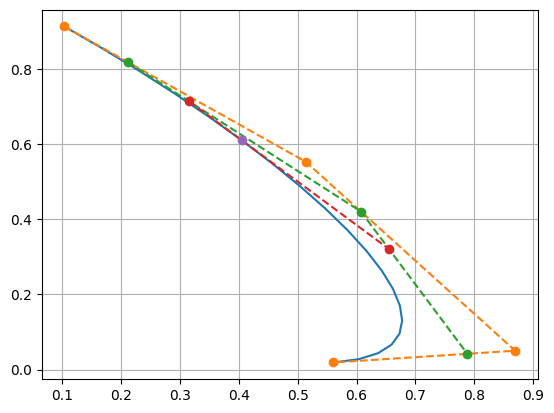

In [6]:
def bezier_3(t, q, p1, p2, p3, p4):
    p123, [p12, p23] = bezier_2(t, q, p1, p2, p3)
    p234, [p23, p34] = bezier_2(t, q, p2, p3, p4)
    p1234 = q * p123 + t * p234
    return p1234, [[p123, p234], [p12, p23, p34]]

def draw_bezier_3(p, verbose=True):
    t = np.linspace(0, 1, 20).reshape((-1, 1))
    curve, [p123_234, p12_23_34] = bezier_3(t, 1-t, p[0, :], p[1, :], p[2, :], p[3, :])
    p123_234 = np.array(p123_234)
    p12_23_34 = np.array(p12_23_34)

    plt.plot(curve[:, 0], curve[:, 1])
    if verbose:
        plt.plot(p[:, 0], p[:, 1], 'o--')
        plt.plot(p12_23_34[:, 5, 0], p12_23_34[:, 5, 1], 'o--')
        plt.plot(p123_234[:, 5, 0], p123_234[:, 5, 1], 'o--')
        plt.plot(curve[5, 0], curve[5, 1], 'o--')

plt.grid()
p = np.random.random((4, 2))
draw_bezier_3(p)

### Curve Split

In [7]:
import sympy as sp

def get_split_trans_func(n, verbose=True):
    t, z = sp.symbols('t z')
    matrix_t = sp.Matrix.hstack(*[sp.Matrix([t**i]) for i in range(n+1)])
    k1 = sp.Matrix.vstack(*[matrix_t.subs(t, i) for i in range(n+1)])
    bezier_matrix = get_bezier_matrix(n)

    left_matrix_tz = sp.Matrix.hstack(*[sp.Matrix([(z*t)**i]) for i in range(n+1)])
    k2 = sp.Matrix.vstack(*[left_matrix_tz.subs(t, i) for i in range(n+1)])
    left_trans_matrix = bezier_matrix.inv() * k1.inv() * k2 * bezier_matrix

    right_matrix_tz = sp.Matrix.hstack(*[sp.Matrix([((1-z)*t + z)**i]) for i in range(n+1)]).expand()
    k2 = sp.Matrix.vstack(*[right_matrix_tz.subs(t, i) for i in range(n+1)])
    right_trans_matrix = bezier_matrix.inv() * k1.inv() * k2 * bezier_matrix
    if verbose:
        display(left_trans_matrix, right_trans_matrix)
    return sp.utilities.lambdify(z, left_trans_matrix, 'numpy'), sp.utilities.lambdify(z, right_trans_matrix, 'numpy')

left, right = get_split_trans_func(3)
left(0.2)

Matrix([
[                       1,                     0,                0,    0],
[                   1 - z,                     z,                0,    0],
[          z**2 - 2*z + 1,         -2*z**2 + 2*z,             z**2,    0],
[-z**3 + 3*z**2 - 3*z + 1, 3*z**3 - 6*z**2 + 3*z, -3*z**3 + 3*z**2, z**3]])

Matrix([
[-z**3 + 3*z**2 - 3*z + 1, 3*z**3 - 6*z**2 + 3*z, -3*z**3 + 3*z**2, z**3],
[                       0,        z**2 - 2*z + 1,    -2*z**2 + 2*z, z**2],
[                       0,                     0,            1 - z,    z],
[                       0,                     0,                0,    1]])

array([[1.   , 0.   , 0.   , 0.   ],
       [0.8  , 0.2  , 0.   , 0.   ],
       [0.64 , 0.32 , 0.04 , 0.   ],
       [0.512, 0.384, 0.096, 0.008]])

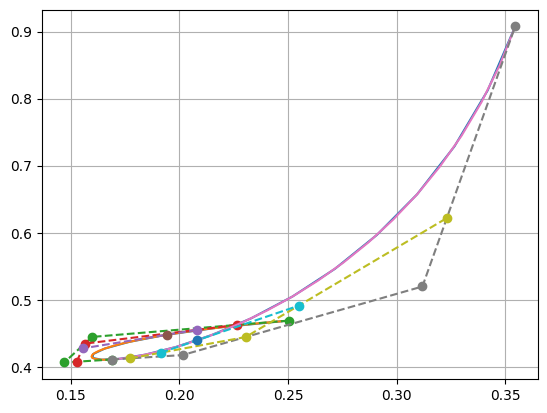

In [8]:
def get_split_p(n, z, p):
    left, right = get_split_trans_func(n, verbose=False)
    return left(z) @ p, right(z) @ p

z = 0.4
p = np.random.random((4, 2))
left_p, right_p = get_split_p(3, z, p)
draw_bezier_3(p, verbose=False)
draw_bezier_3(left_p, verbose=True)
draw_bezier_3(right_p, verbose=True)
plt.grid()

### Increase-Descrease Dim

In [9]:
k5 = get_bezier_matrix(5)
k4 = get_bezier_matrix(4)
display(k5, k4)

Matrix([
[  1,   0,   0,   0,  0, 0],
[ -5,   5,   0,   0,  0, 0],
[ 10, -20,  10,   0,  0, 0],
[-10,  30, -30,  10,  0, 0],
[  5, -20,  30, -20,  5, 0],
[ -1,   5, -10,  10, -5, 1]])

Matrix([
[ 1,   0,   0,  0, 0],
[-4,   4,   0,  0, 0],
[ 6, -12,   6,  0, 0],
[-4,  12, -12,  4, 0],
[ 1,  -4,   6, -4, 1]])